In [1]:
import numpy as np
import pandas as pd
import os
!pip install yahooquery
import yahooquery
from pandas_datareader import data
!pip install nltk==3.3
from datetime import timedelta, date, datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 5.5MB 25.6MB/s 
  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp37-none-any.whl size=7012 sha256=4c59a463c43d3cd472544bfa45c72e149b15ef0f069e64fc9a76f223ce5e4427
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 1.4MB 4.1MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp37-none-any.whl size=1394470 sha256=9932909fb3c192829c68885b0abee451a2dddedcb5b1c973e7668b70bcd90fbd
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Get historical stock data

In [3]:
def get_yahoo_dataframe(symbol):
  # Get historical data
  #symbol = 'AAPL'
  ticker = yahooquery.Ticker(symbol)
  df = pd.DataFrame(ticker.history(start='2020-06-01', end='2021-01-29'))
  df=data.DataReader(symbol, 'yahoo', '20200601', '20210129').reset_index()
  df = df[['Date','Adj Close', 'Volume']]
  (df[:10].style.format(dict(Date='{:%d/%m/%Y}'))
  .background_gradient(subset='Volume',cmap='Blues')
  .background_gradient(subset='Adj Close',cmap='Blues')
  )
  df.Volume.plot()
  df["Adj Close"].plot()
  dates = pd.DataFrame(pd.date_range('20200601',periods=8*31))
  df.set_index(pd.to_datetime(df['Date']), inplace=True)
  df = df.drop(['Date'], axis=1)
  return df

In [4]:
def process_stock_data(filename, df):
  stock_file = pd.read_csv(filename)
  stock_file.set_index(pd.to_datetime(stock_file['Date']), inplace=True)
  stock_file.drop('Date', axis=1)
  stock_file = stock_file.reindex(df.index, method='bfill')
  #stock_file = stock_file.drop('Date', axis=1)
  #stock_file = stock_file.drop('Period Ending', axis=1)
  return stock_file

In [5]:
# Optional, just because Ish is using Colab
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Get news sentiment

In [7]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def get_yahoo_news(symbol):
  start_date = date(2020, 6, 1)
  end_date = date(2021, 1, 29)
  data = []
  run_Dict = []
  ticker = yahooquery.Ticker(symbol)
  for single_date in daterange(start_date, end_date):
      daily_news = ticker.news(start=single_date.strftime("%Y-%m-%d"))
      for article in daily_news:
          #print(article)
          title = article['title']
          if title in run_Dict:
              continue
          else:
              try:
                  run_Dict.append(title)
                  publisher_time = article['provider_publish_time']
                  publisher_time = datetime.utcfromtimestamp(int(publisher_time)).strftime('%Y-%m-%d')
                  data.append([publisher_time, title, article['summary']])
              except KeyError:
                  print("KeyError generated.")
                  continue
          if len(run_Dict) > 30:
              run_Dict = run_Dict[-30:]
  print(len(data))
  news = pd.DataFrame(data, columns=["date", "Title", "Summary"])
  nltk.download("vader_lexicon")
  sentimentAnalyser = SentimentIntensityAnalyzer()
  news["compound"] = [sentimentAnalyser.polarity_scores(v)['compound'] for v in news["Summary"]]
  news["negative"] = [sentimentAnalyser.polarity_scores(v)['neg'] for v in news["Summary"]]
  news["positive"] = [sentimentAnalyser.polarity_scores(v)['pos'] for v in news["Summary"]]
  news["neutral"] = [sentimentAnalyser.polarity_scores(v)['neu'] for v in news["Summary"]]
  news = news.sort_values(by="date")
  return news

In [8]:
def get_sentiment_from_news(news):
  news_sentiment = news[['date', 'compound']]
  print(news_sentiment)
  news_sentiment.set_index(pd.to_datetime(news_sentiment['date']), inplace=True)
  print(news_sentiment[:10])
  news_sentiment = news_sentiment['compound']
  total_sentiment = news_sentiment.groupby('date').agg(lambda x: sum(x))
  total_sentiment = total_sentiment.rename('Total Sentiment')
  nArticles = news_sentiment.groupby('date').count()
  avg_sentiment = total_sentiment/nArticles
  avg_sentiment = avg_sentiment.rename('Avg Sentiment')
  sentiment_data = pd.concat([total_sentiment, avg_sentiment], axis=1)
  sentiment_data = sentiment_data.reindex(df.index, method='ffill')
  return sentiment_data

In [ ]:
# df = df.drop('Estimated_Revenue', axis=1)
# df = df.drop('Reported_Revenue', axis=1)
# df = df.drop('Date', axis=1)
# df = df.drop('Estimated_EPS', axis=1)
# # df = df.drop('Reported_EPS', axis=1)
# df = df.drop('Period Ending', axis=1)

# Output prep

In [27]:
def prepare_data_Y_for_ML(df):
  output = df['Adj Close']
  output.rename('Stock Price')
  advance = df['Adj Close'].shift(10)
  advance = advance.rename('Short Term Advance')
  advance2 = df['Adj Close'].shift(40)
  advance2 = advance2.rename('Mid Term Advance')
  gt = pd.concat([output, advance, advance2], axis=1)
  gt['Short Term Change'] = ((gt['Short Term Advance'] - gt['Adj Close'])/gt['Adj Close'])*100
  gt['Mid Term Change'] = ((gt['Mid Term Advance'] - gt['Adj Close'])/gt['Adj Close'])*100
  #print(gt[9:110])
  #gt['Short Term Change'].plot()

  Y = gt['Short Term Change'][10:]
  return Y

In [28]:
def prepare_data_X_for_ML(df):
  df['Weekly Sentiment'] = df['Avg Sentiment'].rolling(5, win_type='triang').sum()
  df['Monthly Sentiment'] = df['Avg Sentiment'].rolling(20, win_type='triang').sum()
  avg_monthly_sentiment = df['Monthly Sentiment'].sum()/len(df['Monthly Sentiment'])
  avg_week = df['Weekly Sentiment'].sum()/len(df['Monthly Sentiment'])
  X = df[10:]
  X['Monthly Sentiment'] =  X['Monthly Sentiment'].fillna(avg_monthly_sentiment)
  X['Weekly Sentiment'] = X['Weekly Sentiment'].fillna(avg_week)
  X=X.drop(['Date','Estimated_Revenue','Reported_Revenue','Estimated_EPS','Reported_EPS','Period Ending'],axis=1)
  return X

# Test MLP regression

In [11]:
def apply_MLP(X_train,X_test,y_train,y_test):
  sc_X = StandardScaler()
  X_trainscaled=sc_X.fit_transform(X_train)
  X_testscaled=sc_X.transform(X_test)
  reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)
  y_pred=reg.predict(X_testscaled)
  print("The Score with ", (r2_score(y_pred, y_test)))
  y_pred = pd.DataFrame(y_pred)
  out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)
  out = out.rename(columns={0:"Prediction", "Short Term Change":"Ground Truth"})
  return out

# Main code

                  Date Period Ending  ...  Estimated_Revenue  Reported_Revenue
Date                                  ...                                     
2020-06-01  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-02  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-03  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-04  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-05  2020-04-30    2020-03-01  ...           53668.84           58313.0
...                ...           ...  ...                ...               ...
2021-01-25  2020-10-29    2020-09-01  ...           63388.91           64698.0
2021-01-26  2020-10-29    2020-09-01  ...           63388.91           64698.0
2021-01-27  2021-01-27    2020-12-01  ...          102512.80          111439.0
2021-01-28  2021-01-27    2020-12-01  ...          102512.80          111439.0
2021-01-29  2021-01-27    2020-12-01  ...          1

,Adj Close,Volume,Date,Period Ending,Estimated_EPS,Reported_EPS,Surprise_EPS,Estimated_Revenue,Reported_Revenue,Total Sentiment,Avg Sentiment
Date,,,,,,,,,,,
2020-06-01,80.059723,80791200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.2498,-0.312450
2020-06-02,80.430351,87642800.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100
2020-06-03,80.873131,104491200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100
2020-06-04,80.176636,87560400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557
2020-06-05,82.460152,137250400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,142.706757,157611700.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0,6.3311,0.263796
2021-01-26,142.946396,98390600.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0,9.4487,0.363412
2021-01-27,141.848038,140843800.0,2021-01-27,2020-12-01,1.41,1.68,0.27,102512.80,111439.0,3.4509,0.156859


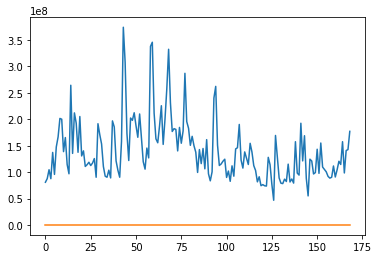

In [13]:
symbol='AAPL'
df = get_yahoo_dataframe(symbol)
df
stock_file=process_stock_data('/content/gdrive/My Drive/Colab Notebooks/earnings_data/AAPL.csv', df)
#print(stock_file)
df = df.join(stock_file)
news=get_yahoo_news(symbol)
#print(news)
sentiment_data=get_sentiment_from_news(news)
#print(sentiment_data)
df = df.join(sentiment_data)
df


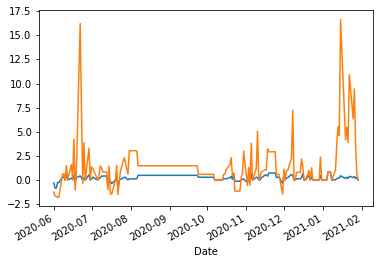

In [15]:
df['Avg Sentiment'].plot()
df['Total Sentiment'].plot()


1226
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
            date  compound
23    2020-05-13    0.6124
22    2020-05-14    0.4404
21    2020-05-14   -0.4854
20    2020-05-15    0.4019
18    2020-05-15   -0.7089
...          ...       ...
1225  2021-01-27    0.1779
841   2021-02-05    0.3818
1081  2021-02-16   -0.3832
609   2021-02-18    0.4576
1177  2021-02-25    0.0000

[1226 rows x 2 columns]
                  date  compound
date                            
2020-05-13  2020-05-13    0.6124
2020-05-14  2020-05-14    0.4404
2020-05-14  2020-05-14   -0.4854
2020-05-15  2020-05-15    0.4019
2020-05-15  2020-05-15   -0.7089
2020-05-15  2020-05-15    0.0000
2020-05-15  2020-05-15    0.7184
2020-05-19  2020-05-19    0.4939
2020-05-19  2020-05-19    0.4939
2020-05-19  2020-05-19    0.3612


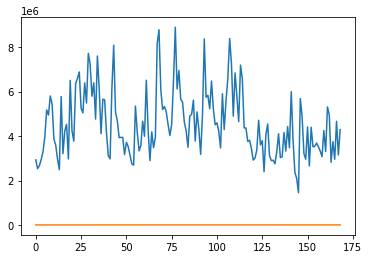

In [24]:
symlist = ['AAPL', 'ADI', 'AMT', 'AMZN', 'BABA', 'COUP', 'CRM', 'ERIC', 'GOOGL', 'MELI', 'MSFT', 'NVDA', 'OKTA', 'PANW', 'PYPL', 'QCOM', 'SHOP', 'SQ', 'TMUS']
symbol=symlist[3]
df = get_yahoo_dataframe(symbol)
stock_file=process_stock_data('/content/gdrive/My Drive/Colab Notebooks/earnings_data/{}.csv'.format(symbol), df)
#print(stock_file)
df = df.join(stock_file)
news=get_yahoo_news(symbol)
#print(news)
sentiment_data=get_sentiment_from_news(news)
#print(sentiment_data)
df = df.join(sentiment_data)


,Adj Close,Volume,Date,Period Ending,Estimated_EPS,Reported_EPS,Surprise_EPS,Estimated_Revenue,Reported_Revenue,Total Sentiment,Avg Sentiment
Date,,,,,,,,,,,
2020-06-01,2471.040039,2928900,2020-04-30,2020-03-01,6.36,5.01,-1.35,74363.20,75452.0,-2.1513,-0.358550
2020-06-02,2472.409912,2529900,2020-04-30,2020-03-01,6.36,5.01,-1.35,74363.20,75452.0,-1.6542,-0.827100
2020-06-03,2478.399902,2671000,2020-04-30,2020-03-01,6.36,5.01,-1.35,74363.20,75452.0,0.5464,0.136600
2020-06-04,2460.600098,2948700,2020-04-30,2020-03-01,6.36,5.01,-1.35,74363.20,75452.0,2.2792,0.569800
2020-06-05,2483.000000,3306400,2020-04-30,2020-03-01,6.36,5.01,-1.35,74363.20,75452.0,0.3558,0.088950
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,3294.000000,3749800,2020-10-29,2020-09-01,7.30,12.37,5.07,92918.16,96145.0,5.4421,0.259148
2021-01-26,3326.129883,2955200,2020-10-29,2020-09-01,7.30,12.37,5.07,92918.16,96145.0,5.9345,0.247271
2021-01-27,3232.580078,4660200,2020-10-29,2020-09-01,7.30,12.37,5.07,92918.16,96145.0,6.5554,0.273142


In [29]:



Y=prepare_data_Y_for_ML(df)
#print(Y)
X=prepare_data_X_for_ML(df)
#print(X)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)
out=apply_MLP(X_train,X_test,y_train,y_test)
#print(out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The Score with  -0.22951486382301223


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [31]:
out

,Ground Truth,Prediction
0,-3.179855,1.344718
1,-2.607869,0.961288
2,6.352953,-1.678954
3,-5.242579,-5.288768
4,4.369721,0.411636
5,-2.550264,1.454294
6,5.004060,1.411856
7,-1.220303,-4.977093
8,-6.405386,-3.198584
9,-7.809624,-9.768319


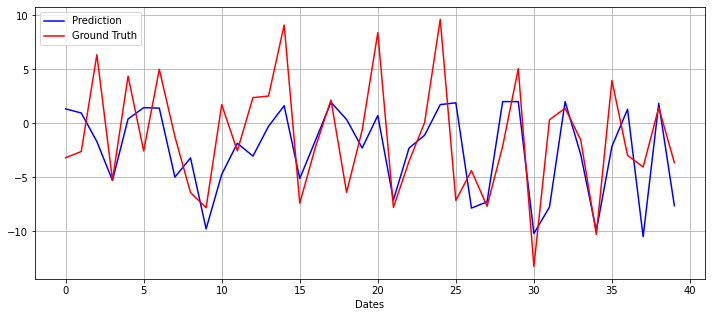

In [30]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')

ax1 = out["Prediction"].plot(color='blue', grid=True)
ax2 = out["Ground Truth"].plot(color='red', grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()


# Test SVM (ToDo: One hot coding and SVM)

In [ ]:
# One hot encoding
Y.plot()
for i,yi in enumerate(Y):
  if yi<-2:
    Y[i] =0
  elif yi<2:
    Y[i]=1
  else:
    Y[i]=2


#Y[0]=1
print(Y)

#print(Y)

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, Y_train)
clf.predict(X_test)

In [ ]:
X = df[40:]
X['Monthly Sentiment'] =  X['Monthly Sentiment'].fillna(avg_monthly_sentiment)
X['Weekly Sentiment'] = X['Weekly Sentiment'].fillna(avg_week)

In [ ]:
Y = gt['Mid Term Change'][40:]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [ ]:
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [ ]:
reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)

In [ ]:
y_pred=reg.predict(X_testscaled)
print("The Score with ", (r2_score(y_pred, y_test)))

In [ ]:
y_pred = pd.DataFrame(y_pred)
out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)

In [ ]:
out = out.rename(columns={0:"Prediction", "Mid Term Change":"Ground Truth"})

In [ ]:
out

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')

ax1 = out["Prediction"].plot(color='blue', grid=True)
ax2 = out["Ground Truth"].plot(color='red', grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()
